# 􏰖􏰗􏰤􏰚SDSP Exam - COMPANY BANKRUPTCY PREDICTIVE MODEL - Group 10

## Import dataset

In [1]:
#import data for bankruptcy
import pandas as pd

df = spark.read.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
.option('delimiter', ",").option('header', 'true').option("inferSchema", "true").load('CompanyBankruptcyPrediction.csv')

pd.DataFrame(df.take(11), columns=df.columns)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,1,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,1,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,1,0.030801


## Preliminary analysis and feature engineering

In [2]:
#let's check how balanced are the classes
df.groupby("Bankrupt?").count().show()

+---------+-----+
|Bankrupt?|count|
+---------+-----+
|        1|  220|
|        0| 6599|
+---------+-----+



In [3]:
#identify columns tha contain just one value, the so called 'zero variance predictors'.
#two value columns were identified as well
col_distinct = df.toPandas().nunique(axis=0)
zvp = []
for k, v in col_distinct.iteritems():
    if v == 1 or v == 2:
        zvp.append(k)
zvp

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

In [4]:
#this attribute and value (Liability>Assets) makes no sense in terms of accounting principles
df.groupby(zvp[1]).count().show()

#additional research on the dataset showed some identical columns
df.select(' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Net Value Per Share (C)').show(10)
zvp.extend([' Net Value Per Share (B)', ' Net Value Per Share (C)'])
print(zvp)

+----------------------+-----+
| Liability-Assets Flag|count|
+----------------------+-----+
|                     1|    8|
|                     0| 6811|
+----------------------+-----+

+------------------------+------------------------+------------------------+
| Net Value Per Share (A)| Net Value Per Share (B)| Net Value Per Share (C)|
+------------------------+------------------------+------------------------+
|       0.147949938898487|       0.147949938898487|       0.147949938898487|
|       0.182251064009102|       0.182251064009102|       0.182251064009102|
|       0.177910749652353|       0.177910749652353|       0.193712865028865|
|       0.154186507100417|       0.154186507100417|       0.154186507100417|
|       0.167502422991024|       0.167502422991024|       0.167502422991024|
|        0.15557709325355|        0.15557709325355|        0.15557709325355|
|       0.158821794277527|       0.158821794277527|       0.158821794277527|
|       0.176983692216931|       0.17698369

In [5]:
#we are going to delete our label attribute in the 'zero variance predictors' list, and drop the cols
zvp.remove('Bankrupt?')
print(zvp)
df = df.drop(*zvp)
len(df.columns)

[' Liability-Assets Flag', ' Net Income Flag', ' Net Value Per Share (B)', ' Net Value Per Share (C)']


92

In [6]:
#cleaned dataset
pd.DataFrame(df.take(6), columns=df.columns)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.118250,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.025346,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.067250,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.047725,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.099522,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,0.019534


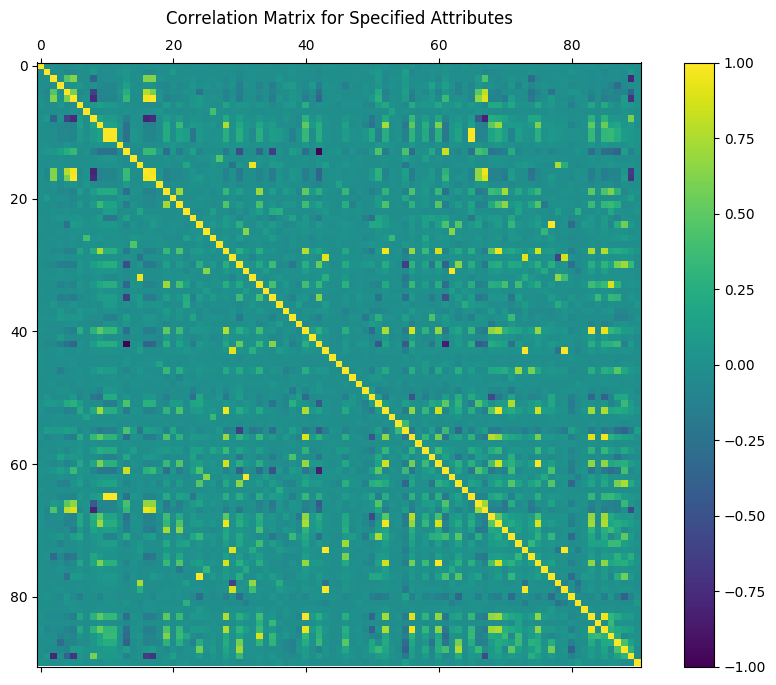

In [7]:
#let's check if is present collinearity between independent variables
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

c = list(set(df.columns) - {'Bankrupt?'})
assembler = VectorAssembler(inputCols=c, outputCol="features")

myGraph_vector = assembler.transform(df).select('features')
matrix = Correlation.corr(myGraph_vector, 'features').collect()[0][0]
corrmatrix = matrix.toArray().tolist()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no, figsize=(11,8), dpi= 100)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
    
plot_corr_matrix(corrmatrix, c, 234)
#seems we do not have to worry!

In [8]:
#let's create the feature vector with all the Xs (the first column contains the Y label)
from pyspark.ml.feature import VectorAssembler

c = list(set(df.columns) - {'Bankrupt?'})
assembler = VectorAssembler(inputCols=c, outputCol="features")
df_features=assembler.transform(df)

df_features.printSchema()
pd.DataFrame(df_features.take(11), columns=df_features.columns) 

root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax rate (A): double (nullable = t

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,features
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,"[0.564050112276341, 0.000326977269203033, 0.00..."
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,"[0.570174946412453, 0.0004430401005442, 0.0058..."
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,"[0.563706076496047, 0.000396425314703456, 0.00..."
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,"[0.564663420271241, 0.000382425906321948, 0.00..."
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,"[0.575616645216918, 0.000438947581872957, 0.00..."
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,0.019534,"[0.56453833936354, 0.000351781925051909, 0.005..."
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,0.015663,"[0.564200119780965, 0.000351756970669767, 0.00..."
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,0.034889,"[0.566088941755739, 0.000451050457211694, 0.00..."
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,0.065826,"[0.565591901310376, 0.00045272240081519, 0.005..."
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,0.030801,"[0.566667622359207, 0.00044491167920483, 0.005..."


In [9]:
#we need to scale all the features to avoid instability due to different ranges
from pyspark.ml.feature import StandardScaler

#indicate which column you want to scale
scaler1 = StandardScaler(inputCol="features", outputCol="scaled_features")

# Compute summary statistics and generate StandardScalerModel 
scaler_model1 = scaler1.fit(df_features)

# rescale each feature
scaled_df = scaler_model1.transform(df_features)
scaled_df.printSchema()
scaled_df.select("features", "scaled_features").show()

root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax rate (A): double (nullable = t

## Training/test set split

In [10]:
#now we have a proper dataset to use for building the model
#extract a trainig set and test set from the dataset randomly (80% training and 20% test)
training_data, testing_data = scaled_df.randomSplit([.8,.2],seed=1234)
print("Training Set Count: " + str(training_data.count()))
print("Test Set Count: " + str(testing_data.count()))

Training Set Count: 5471
Test Set Count: 1348


## Classification model 1: Logistic regression

In [11]:
#run classification with logistic regression on the training set to learn the model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(threshold=0.55, labelCol="Bankrupt?", featuresCol="scaled_features",maxIter=100)
modelLr=lr.fit(training_data)
predict_trainLr=modelLr.transform(training_data)
predict_testLr=modelLr.transform(testing_data)
predict_testLr.select("Bankrupt?","prediction").show(5)

+---------+----------+
|Bankrupt?|prediction|
+---------+----------+
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       0.0|
|        0|       1.0|
+---------+----------+
only showing top 5 rows



In [12]:
#results counter
import pyspark.sql.functions as f

checkLr = predict_testLr.withColumn('Outcome', f.when(f.col('Bankrupt?') == f.col('prediction'), 'OK predicted').otherwise('KO predicted'))
checkLr.groupby("Outcome").count().show()

+------------+-----+
|     Outcome|count|
+------------+-----+
|OK predicted| 1311|
|KO predicted|   37|
+------------+-----+



In [13]:
#ROC evaluation (value)
print("areaUnderROC: " + str(round(modelLr.summary.areaUnderROC, 3)))

areaUnderROC: 0.95


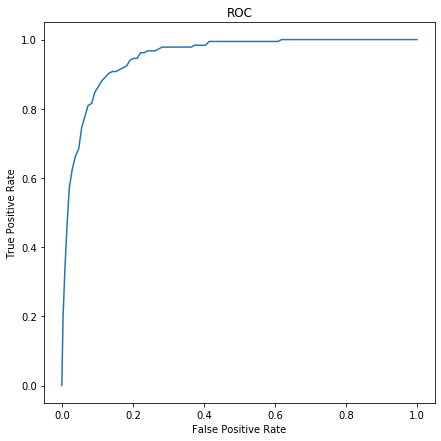

In [14]:
#ROC evaluation (plot)
modelLr.summary.roc.select('FPR').collect()
modelLr.summary.roc.select('TPR').collect()

plt.figure(figsize=(7,7))
plt.plot(modelLr.summary.roc.select('FPR').collect(),
         modelLr.summary.roc.select('TPR').collect())
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#it seems good!

In [15]:
#classify elements: TP, TN, FN and FP
checkLr = predict_testLr.withColumn('Outcome', f.when(f.col('Bankrupt?') + f.col('prediction') == 0,'TN')\
                                    .when(f.col('Bankrupt?') > f.col('prediction'), 'FN')\
                                    .when(f.col('Bankrupt?') < f.col('prediction'), 'FP')
                                    .otherwise('TP'))

countLr = checkLr.groupby("Outcome").count()
countLr.show()

+-------+-----+
|Outcome|count|
+-------+-----+
|     TP|    8|
|     TN| 1303|
|     FN|   28|
|     FP|    9|
+-------+-----+



In [16]:
#let's calculate precision and recall
tp = countLr.select("count").where("Outcome == 'TP'").first()["count"]
fn = countLr.select("count").where("Outcome == 'FN'").first()["count"]
fp = countLr.select("count").where("Outcome == 'FP'").first()["count"]
precisionLr = tp /(tp+fp)
recallLr = tp /(tp+fn)
print("Precision: " + str(round(precisionLr, 2)))
print("Recall: " + str(round(recallLr, 2)))

Precision: 0.47
Recall: 0.22


## Classification model 2: Decision tree

In [17]:
#let's see if decision tree is a better performing model
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Bankrupt?", featuresCol="scaled_features")
modelDt=dt.fit(training_data)
predict_trainDt=modelDt.transform(training_data)
predict_testDt=modelDt.transform(testing_data)
predict_testDt.select("Bankrupt?","prediction").show(5)

+---------+----------+
|Bankrupt?|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       1.0|
+---------+----------+
only showing top 5 rows



In [18]:
#classify elements: TP, TN, FN and FP
checkDt = predict_testDt.withColumn('Outcome', f.when(f.col('Bankrupt?') + f.col('prediction') == 0,'TN')\
                                    .when(f.col('Bankrupt?') > f.col('prediction'), 'FN')\
                                    .when(f.col('Bankrupt?') < f.col('prediction'), 'FP')
                                    .otherwise('TP'))

countDt = checkDt.groupby("Outcome").count()
countDt.show()

+-------+-----+
|Outcome|count|
+-------+-----+
|     TP|    8|
|     TN| 1302|
|     FN|   28|
|     FP|   10|
+-------+-----+



In [19]:
#let's calculate precision and recall
tp = countDt.select("count").where("Outcome == 'TP'").first()["count"]
fn = countDt.select("count").where("Outcome == 'FN'").first()["count"]
fp = countDt.select("count").where("Outcome == 'FP'").first()["count"]
precisionDt = tp /(tp+fp)
recallDt = tp /(tp+fn)
print("Precision: " + str(round(precisionDt, 2)))
print("Recall: " + str(round(recallDt, 2)))

Precision: 0.44
Recall: 0.22


## Undersampling
We are going to perform a undersampling operation in order to get hopefully better result on Precision and Recall.

So far we operated with 97% "0 labeled data" and just 3% "1 labeled data".

Let's see how things change.

In [20]:
from pyspark.sql.functions import col

maj_df = scaled_df.filter(col("Bankrupt?") == 0)
min_df = scaled_df.filter(col("Bankrupt?") == 1)
ratio = int(maj_df.count()/min_df.count())
print("ratio: {}".format(ratio))

ratio: 29


In [21]:
red_maj_df = maj_df.sample(False, 1/ratio)
bal_scaled_df = red_maj_df.unionAll(min_df)
pd.DataFrame(bal_scaled_df.take(11), columns=bal_scaled_df.columns)
bal_scaled_df.groupby("Bankrupt?").count().show()

+---------+-----+
|Bankrupt?|count|
+---------+-----+
|        1|  220|
|        0|  240|
+---------+-----+



In [22]:
#split again with the new dataset!
training_bal_data, testing_bal_data = bal_scaled_df.randomSplit([.8,.2],seed=1234)
print("Training Set Count: " + str(training_bal_data.count()))
print("Test Set Count: " + str(testing_bal_data.count()))

Training Set Count: 380
Test Set Count: 80


In [23]:
#logistic regression results with new model
lr2 = LogisticRegression(threshold=0.55, labelCol="Bankrupt?", featuresCol="scaled_features",maxIter=100)
modelLr2=lr2.fit(training_bal_data)
predict_trainLr2=modelLr2.transform(training_bal_data)
predict_testLr2=modelLr2.transform(testing_bal_data)
checkLr2 = predict_testLr2.withColumn('Outcome', f.when(f.col('Bankrupt?') + f.col('prediction') == 0,'TN')\
                                    .when(f.col('Bankrupt?') > f.col('prediction'), 'FN')\
                                    .when(f.col('Bankrupt?') < f.col('prediction'), 'FP')
                                    .otherwise('TP'))
countLr2 = checkLr2.groupby("Outcome").count()
tp2 = countLr2.select("count").where("Outcome == 'TP'").first()["count"]
fn2 = countLr2.select("count").where("Outcome == 'FN'").first()["count"]
fp2 = countLr2.select("count").where("Outcome == 'FP'").first()["count"]
precisionLr2 = tp2 /(tp2+fp2)
recallLr2 = tp2 /(tp2+fn2)
print("Precision: " + str(round(precisionLr2, 2)))
print("Recall: " + str(round(recallLr2, 2)))

#we improved by a factor of 2.5 (on avg.) in both results!

Precision: 0.82
Recall: 0.76


In [24]:
#decision tree results with new model
dt2 = DecisionTreeClassifier(labelCol="Bankrupt?", featuresCol="scaled_features")
modelDt2=dt2.fit(training_bal_data)
predict_trainDt2=modelDt2.transform(training_bal_data)
predict_testDt2=modelDt2.transform(testing_bal_data)
checkDt2 = predict_testDt2.withColumn('Outcome', f.when(f.col('Bankrupt?') + f.col('prediction') == 0,'TN')\
                                    .when(f.col('Bankrupt?') > f.col('prediction'), 'FN')\
                                    .when(f.col('Bankrupt?') < f.col('prediction'), 'FP')
                                    .otherwise('TP'))
countDt2 = checkDt2.groupby("Outcome").count()
tp2 = countDt2.select("count").where("Outcome == 'TP'").first()["count"]
fn2 = countDt2.select("count").where("Outcome == 'FN'").first()["count"]
fp2 = countDt2.select("count").where("Outcome == 'FP'").first()["count"]
precisionDt2 = tp2 /(tp2+fp2)
recallDt2 = tp2 /(tp2+fn2)
print("Precision: " + str(round(precisionDt2, 2)))
print("Recall: " + str(round(recallDt2, 2)))

#we improved by a factor of 2.5 (on avg.) in both results!

Precision: 0.73
Recall: 0.78


# Final comments:
Unlike the ROC curve, precision and recalls are very sensitive to imbalanced classes. 

If you optimize your classifier for good AUC on an unbalanced data you are likely to obtain poor precision-recall results. 

That's happen of course because the randomic split in the training/test set that does not allow to the model to properly learn the "bankruptcy" feature.

Through the undersampling technique we were able to improve significantly the results, pointing out that in case we want maximise Precision, Logistic Regression seems to perform better than Decision Tree.

Vice versa could be slightly stated for Recall maximization. 